In [1]:
import os
import time
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt

from utils import logger_info, logger_close, find_last_checkpoint
from utils import load_data, missing_pattern, compute_rmse, compute_mape

from utils_lrtc import unfolding, folding, shrinkage, svd_

dataroot = "./datasets"
paramsroot = "./drunet_light_params"
save_dir = "./loggers"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
def svt_scad(mat, tau, gamma=20, lamb=10):
    u, s, v = svd_(mat)
    ss = shrinkage(s, [tau, gamma, lamb], mode="scad")
    idx = torch.where(ss > 0)[0]
    return u[:, idx] @ torch.diag(ss[idx]) @ v[idx, :]

def deep_pnp_solver(mat, model, sigma):
    mat = mat.unsqueeze(0).unsqueeze(0)
    max_value = mat.max()
    noise_level_map = torch.ones_like(mat).mul_(sigma).float()

    input = torch.cat([mat / max_value, noise_level_map], dim=1)
    hat_mat = model(input).clamp(0., 1.) * max_value

    return hat_mat.squeeze(0).squeeze(0)

In [3]:
def recover_data(sparse_tensor, dense_tensor, pos_test, rho, gamma, lamb, model, delta, sigma, logger=None, factor=1.05, tol=1e-3, max_iter=200, checkpoint=200):
    # initialization
    alpha = torch.ones(3) / 3
    dim = len(sparse_tensor.shape)
    dimk = list(sparse_tensor.shape)
    dim_k = {k: [dimk[d] for d in range(dim) if d != k] for k in range(dim)}

    M = sparse_tensor.clone()
    pos_missing = torch.where(sparse_tensor == 0)
    M[pos_missing] = torch.mean(sparse_tensor[sparse_tensor != 0])

    # initialize Z, T, A, B    
    Z3 = torch.cat([torch.zeros_like(sparse_tensor).unsqueeze(0) for _ in range(dim)], dim=0) # shape: 3 * dim1 * dim2 * dim3
    T3, A3, B3 = [Z3.clone() for _ in range(3)] # T3, A3, and B3 shape: same as Z3

    max_value = max(sparse_tensor.max(), 1e4)
    min_value = min(sparse_tensor.min(), 0)

    # result recorder
    RMSE = torch.zeros(max_iter+1)
    MAPE = torch.zeros(max_iter+1)
    
    used_time = 0
    for it in range(max_iter):

        # compute the MAPE, RMSE
        mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
        rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
        MAPE[it] = mape.cpu()
        RMSE[it] = rmse.cpu()
        if it % checkpoint == 0:
            logger.info(f"Iter: {it}, MAPE: {mape:.6f}, RMSE: {rmse:.6f}")

        start_time = time.time()

        # update rho
        M_latest = M.clone()
        rho = np.clip(rho * factor, 1e-10, 1e5)

        with torch.no_grad():
            for k in range(dim):
                # update Zk
                M_k = unfolding(M - T3[k] / rho, k)
                Z_k = svt_scad(M_k, alpha[k] / rho, gamma=gamma, lamb=lamb)
                Z3[k] = folding(Z_k, k, dim_k[k])
                del M_k, Z_k

                # update Ak
                M_k = unfolding(M - B3[k] / rho, k)
                A_k = deep_pnp_solver(M_k, model, sigma / 255.)
                A3[k] = folding(A_k, k, dim_k[k])
                del M_k, A_k
        
        # update M
        W = torch.mean(Z3 + T3 / rho, dim=0)
        R = torch.mean(A3 + B3 / rho, dim=0)
        O = (W + delta * R) / (1 + delta)
        M[pos_missing] = O[pos_missing]
        M.clamp_(min_value, max_value)
        
        # update dual variable T
        T3 += rho * (Z3 - torch.cat([M.clone().unsqueeze(0) for _ in range(dim)], dim=0))
        B3 += rho * (A3 - torch.cat([M.clone().unsqueeze(0) for _ in range(dim)], dim=0))

        tole = torch.linalg.norm(M - M_latest) / torch.linalg.norm(M_latest)

        used_time += time.time() - start_time
        # compute the tolerance
        if tole < tol:
            break


    # compute the MAPE, RMSE
    mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
    rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
    MAPE[it] = mape.cpu()
    RMSE[it] = rmse.cpu()
    
    logger.info(f"Total iteration: {it + 1}, Running time: {used_time:.5f}, Tolerance: {tole * 1e5:.2f}e-5, ")
    logger.info(f"Imputation MAPE / RMSE: {mape:.2f} / {rmse:.2f}.")

    return M.cpu(), RMSE[:it+1], MAPE[:it+1], used_time

In [4]:
hyper_parameters = {
    "Hangzhou": {
        "random": [1000., 3., 1e-7, 7.], 
        "non-random": [1000., 3., 1e-7, 7.],
        "blackout": [10000., 1., 1e-7, 7.],
    }, 
    "Portland": {
        "random": [1000., 6., 1e-7, 7.], 
        "non-random": [1000., 6., 1e-7, 7.],
        "blackout": [1000., 6., 1e-7, 7.],
    }, 
    "Seattle": {
        "random": [1000., 1., 1e-7, 7.], 
        "non-random": [1000., 1., 1e-7, 7.],
        "blackout": [1000., 1., 1e-7, 7.],
    },
    "PeMS": {
        "random": [100., 3., 0.5, 7.], 
        "non-random": [100., 3., 0.5, 7.],
        "blackout": [100., 3., 0.5, 7.],
    },
}

missing_rates = {
    "random": [0.3, 0.5, 0.7],
    "non-random": [0.3, 0.5, 0.7],
    "blackout": [0.3, 0.5, 0.7],
}

In [5]:
from utils_drunet.network_unet_light import UNetRes as net
model = net(
    in_nc=2,
    out_nc=1,
    nc=[64, 128, 256],
    nb=4,
    act_mode="R",
    downsample_mode="strideconv",
    upsample_mode="convtranspose",
    bias=False,
    interpolation_mode="bilinear"
    )

_, init_path_G = find_last_checkpoint(paramsroot)
state_dict = torch.load(init_path_G)
if "params" in state_dict.keys():
    state_dict = state_dict["params"]
model.load_state_dict(state_dict, strict=True)
model.eval()

UNetRes(
  (m_head): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (m_down1): Sequential(
    (0): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (2): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (3): ResBlock(
      (res): Sequential(
        (0): Conv

24-11-19 10:22:26.668 : --------------------------------------------------------------------------------------------------------
24-11-19 10:22:26.669 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.


LogHandlers setup!


24-11-19 10:22:27.266 : Iter: 0, MAPE: 27.570040, RMSE: 13.497121
24-11-19 10:25:02.428 : Total iteration: 134, Running time: 153.57882, Tolerance: 87.05e-5, 
24-11-19 10:25:02.432 : Imputation MAPE / RMSE: 2.19 / 1.70.
24-11-19 10:25:02.874 : --------------------------------------------------------------------------------------------------------
24-11-19 10:25:02.875 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:25:02.955 : Iter: 0, MAPE: 27.464575, RMSE: 13.478113


LogHandlers exist!


24-11-19 10:27:41.347 : Total iteration: 134, Running time: 155.97061, Tolerance: 81.44e-5, 
24-11-19 10:27:41.351 : Imputation MAPE / RMSE: 2.50 / 1.99.
24-11-19 10:27:41.552 : --------------------------------------------------------------------------------------------------------
24-11-19 10:27:41.553 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:27:41.638 : Iter: 0, MAPE: 27.468861, RMSE: 13.480422


LogHandlers exist!


24-11-19 10:30:20.022 : Total iteration: 133, Running time: 154.88880, Tolerance: 95.31e-5, 
24-11-19 10:30:20.026 : Imputation MAPE / RMSE: 3.07 / 2.48.
24-11-19 10:30:20.222 : --------------------------------------------------------------------------------------------------------
24-11-19 10:30:20.223 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:30:20.265 : Iter: 0, MAPE: 27.391630, RMSE: 13.477326


LogHandlers setup!


24-11-19 10:32:53.621 : Total iteration: 130, Running time: 151.80045, Tolerance: 99.38e-5, 
24-11-19 10:32:53.625 : Imputation MAPE / RMSE: 6.67 / 4.92.
24-11-19 10:32:54.003 : --------------------------------------------------------------------------------------------------------
24-11-19 10:32:54.004 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:32:54.064 : Iter: 0, MAPE: 27.598280, RMSE: 13.494247


LogHandlers exist!


24-11-19 10:35:33.982 : Total iteration: 133, Running time: 156.02971, Tolerance: 96.60e-5, 
24-11-19 10:35:33.986 : Imputation MAPE / RMSE: 7.51 / 5.36.
24-11-19 10:35:34.453 : --------------------------------------------------------------------------------------------------------
24-11-19 10:35:34.454 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:35:34.524 : Iter: 0, MAPE: 27.606115, RMSE: 13.510813


LogHandlers exist!


24-11-19 10:38:16.701 : Total iteration: 134, Running time: 157.03464, Tolerance: 88.80e-5, 
24-11-19 10:38:16.705 : Imputation MAPE / RMSE: 8.86 / 6.08.
24-11-19 10:38:16.936 : --------------------------------------------------------------------------------------------------------
24-11-19 10:38:16.937 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:38:17.007 : Iter: 0, MAPE: 27.401161, RMSE: 13.448531


LogHandlers setup!


24-11-19 10:40:55.459 : Total iteration: 133, Running time: 156.23661, Tolerance: 97.03e-5, 
24-11-19 10:40:55.464 : Imputation MAPE / RMSE: 6.31 / 4.86.
24-11-19 10:40:55.833 : --------------------------------------------------------------------------------------------------------
24-11-19 10:40:55.835 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:40:55.888 : Iter: 0, MAPE: 26.954666, RMSE: 13.351610


LogHandlers exist!


24-11-19 10:43:35.007 : Total iteration: 133, Running time: 155.77122, Tolerance: 89.08e-5, 
24-11-19 10:43:35.012 : Imputation MAPE / RMSE: 7.33 / 5.43.
24-11-19 10:43:35.427 : --------------------------------------------------------------------------------------------------------
24-11-19 10:43:35.429 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 100.0 	 lamb: 3.0 	 delta: 0.5 	 sigma: 7.0.
24-11-19 10:43:35.491 : Iter: 0, MAPE: 27.274790, RMSE: 13.435456


LogHandlers exist!


24-11-19 10:46:14.558 : Total iteration: 132, Running time: 154.47941, Tolerance: 93.75e-5, 
24-11-19 10:46:14.562 : Imputation MAPE / RMSE: 8.96 / 6.23.


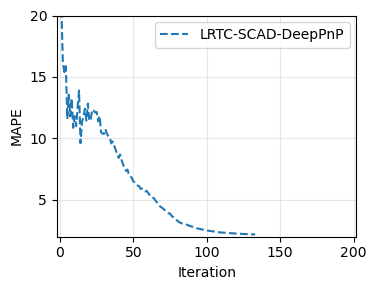

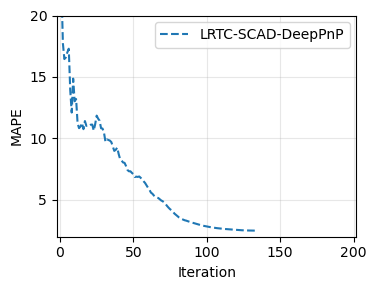

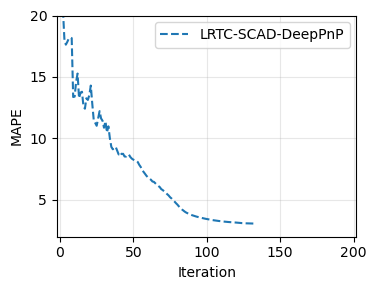

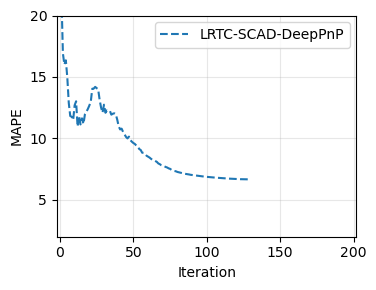

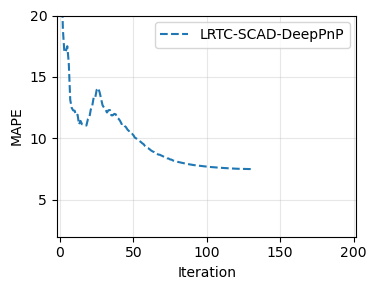

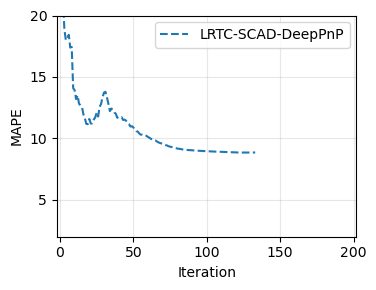

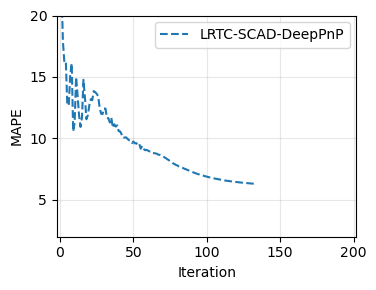

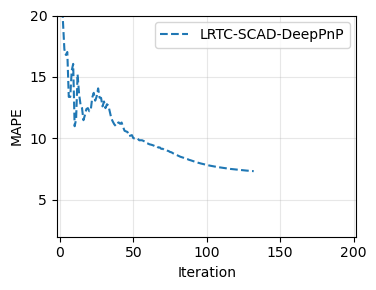

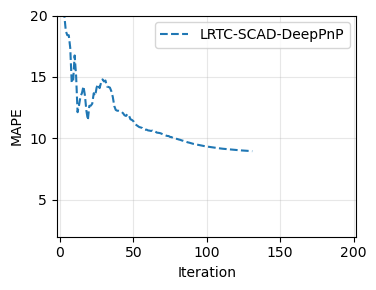

In [6]:
datasets = ["PeMS"]

for dataset_name in datasets:
    for kind in ["random", "non-random", "blackout"]:
        logger_dir = f"scad_deepPnP_{kind}_{dataset_name}"
        logging_save_dir = os.path.join(save_dir, logger_dir)
        # log the iteration results
        if not os.path.exists(logging_save_dir):
            os.makedirs(logging_save_dir)

        initial_rho = 1e-5
        gamma, lamb, delta_factor, sigma = hyper_parameters[dataset_name][kind]
        for missing_rate in missing_rates[kind]:
            logger_info(logger_dir, log_path=os.path.join(logging_save_dir, f"completion_results.log"))
            result_logger = logging.getLogger(logger_dir)
            
            result_logger.info("--------------------------------------------------------------------------------------------------------")
            result_logger.info(f"ms: {missing_rate} \t initial rho: {initial_rho} \t gamma: {gamma} \t lamb: {lamb} \t delta: {delta_factor} \t sigma: {sigma}.")
            dense_tensor = load_data(dataset_name, dataroot)

            if kind == "blackout":
                if dataset_name in ["Seattle", "PeMS"]:
                    block_window = 12
                elif dataset_name in ["Hangzhou", "Portland"]:
                    block_window = 6
                binary_tensor, binary_blocks = missing_pattern(dense_tensor, missing_rate, kind=kind, block_window=block_window)
            else:
                binary_tensor = missing_pattern(dense_tensor, missing_rate, kind=kind)
            
            sparse_tensor = dense_tensor * binary_tensor
            pos_test = torch.where((dense_tensor != 0) & (sparse_tensor == 0))

            M, RMSE, MAPE, used_time = recover_data(
                sparse_tensor.to(device), dense_tensor.to(device), pos_test, # data and test mask
                initial_rho, gamma, lamb, model.to(device), delta_factor, sigma, # algorithm parameters
                logger=result_logger, tol=1e-3, # logger and tolerance
                )
        
            fig = plt.figure(figsize=(4, 3))
            plt.grid(alpha=0.3)
            plt.plot(MAPE, "--", label="LRTC-SCAD-DeepPnP")
            plt.xlabel("Iteration")
            plt.ylabel("MAPE")
            plt.legend()
            plt.axis([-2, 202, 2, 20])
            plt.tight_layout()
            plt.savefig(os.path.join(logging_save_dir, f"missing_rate_{missing_rate}_MAPE.png"), dpi=300, transparent=True)

        logger_close(result_logger)     # close the logger file